In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot
from matplotlib import pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import shutil

In [3]:
shutil.unpack_archive("./data/Traffic_Violations.csv.zip", "./data/", "zip")

In [5]:
data = pd.read_csv("./data/Traffic_Violations.csv", low_memory=False)

In [8]:
data = data.dropna()

In [9]:
charge = data.value_counts(['Charge']).reset_index(name='count')
top_10_charges = charge.head(10)

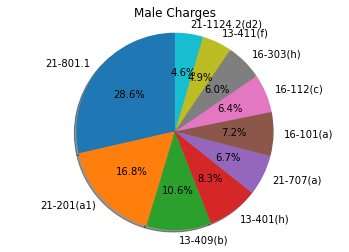

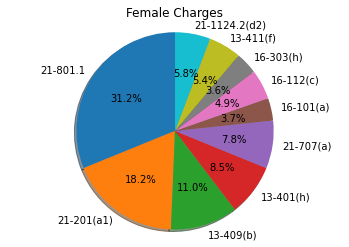

In [11]:
gender_charge = data[['Charge', 'Gender', 'Description']]
gender = data.value_counts(['Gender']).reset_index(name='count')
total_male = gender[gender['Gender'] == 'M'].count

male_charge = {}
female_charge = {}

for charge in top_10_charges.Charge:
    c = gender_charge[gender_charge['Charge'] == charge]
    male = c[c['Gender']=='M']
    female = c[c['Gender']=='F']
    male_charge[charge] = male.shape[0]
    female_charge[charge] = female.shape[0]

fig1, ax1 = plt.subplots()
ax1.pie(male_charge.values(), labels=male_charge.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Male Charges")
# show plot
plt.show()

fig1, ax1 = plt.subplots()
ax1.pie(female_charge.values(), labels=female_charge.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title("Female Charges")
# Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

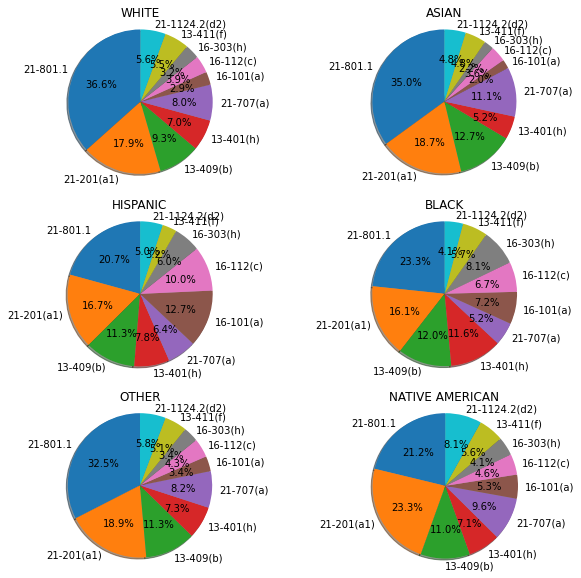

In [12]:
race_charge = data[['Charge', 'Race', 'Description']]
race = data.value_counts(['Race']).reset_index(name='count')
races = race_charge['Race'].unique()
race_charges_list = {}


for race in races:
    
    r_c = race_charge[race_charge['Race'] == race]
    race_vs_charges = {}
    
    for charge in top_10_charges.Charge:
        charg = r_c[r_c['Charge'] == charge]
        race_vs_charges[charge] = charg.shape[0]
    race_charges_list[race] = race_vs_charges

fig1, ax1 = plt.subplots(3,2,figsize= (10,10))
i = 0
races_2D = np.array(races)
B = np.reshape(races_2D, (-1, 2))
for i in range(3):
    for j in range(2):  
        key = B[i][j]
        ax1[i,j].pie(race_charges_list[key].values(), labels=race_charges_list[key].keys(), autopct='%1.1f%%', shadow=True, startangle=90)
        ax1[i,j].axis('equal')
        ax1[i,j].title.set_text(key)
plt.savefig('races_vs_charges')
plt.show()

In [13]:
np_belts_before = np.array([0,0])
np_belts_after = np.array([0,0])

from datetime import datetime
seatbelt_law_date = datetime.strptime("08/01/2013", "%m/%d/%Y")

for index, item in data.iterrows():
    if index % 100 == 0:
        print(index, end="\r")
    temp_date = datetime.strptime(item['Date Of Stop'], "%m/%d/%Y")
    if temp_date.date() <= seatbelt_law_date.date(): # Before the law
        if item.Belts.lower() == "no":
            np_belts_before[1] += 1
        else:
            np_belts_before[0] += 1
    else:
        if item.Belts.lower() == "no":
            np_belts_after[1] += 1
        else:
            np_belts_after[0] += 1
print(f"Belts before: {np_belts_before}")
print(f"Belts after: {np_belts_after}")

np_belts_after_adjusted = np_belts_after
np_belts_after_adjusted[0] = np_belts_after_adjusted[0] / 4
np_belts_after_adjusted[1] = np_belts_after_adjusted[1] / 4

print(f"Adjusted belts after: {np_belts_after_adjusted}")


Belts before: [  7135 215803]
Belts after: [ 25399 623732]
Adjusted belts after: [  6349 155933]


([], [])


<BarContainer object of 2 artists>

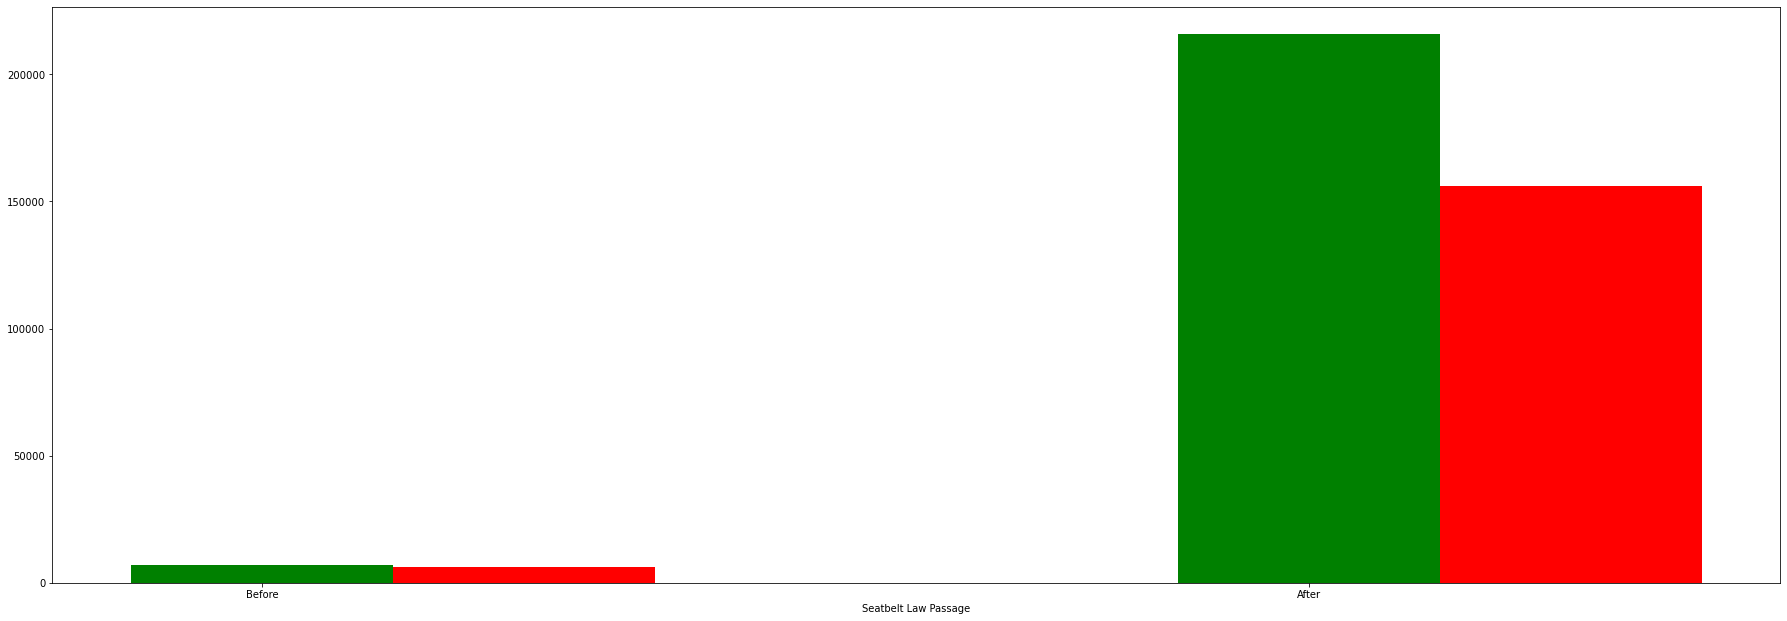

In [14]:
X = np.arange(2)
fig = plt.figure()

ax = fig.add_axes([0,0,4,2])
law_classification = ['Before', 'After']

ax.set_xlabel("Seatbelt Law Passage")
ax.set_xticks(range(2))
ax.set_xticklabels(law_classification)

print(ax.get_legend_handles_labels())

ax.bar(X + 0.00, np_belts_before, color = 'g', width = 0.25)
ax.bar(X + 0.25, np_belts_after_adjusted, color = 'r', width = 0.25)

In [59]:
from sklearn.cluster import KMeans
import numpy as np

d = data[['Geolocation', 'Charge']]
geolocation = np.zeros((len(d), 2))
j = 0
for i in d.Geolocation:
    t = i.replace("(","")
    t = t.replace(")","")
    geolocation[j][0] = float(t.split(',')[0])
    geolocation[j][1] = float(t.split(',')[1])
    j=j+1
        

geolocation = geolocation[geolocation[:,1] < -76.50]
geolocation = geolocation[geolocation[:,0] > 38.75]
size = geolocation.shape[0]

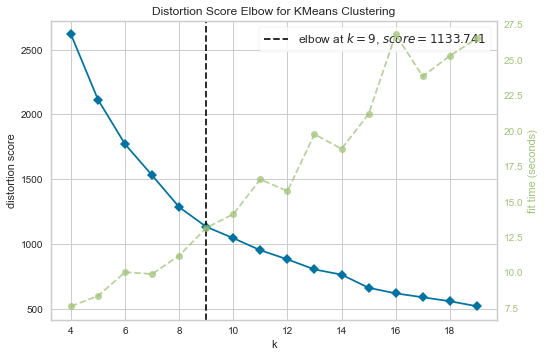

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [50]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,20))

visualizer.fit(geolocation[0:size,])        # Fit the data to the visualizer
visualizer.show()

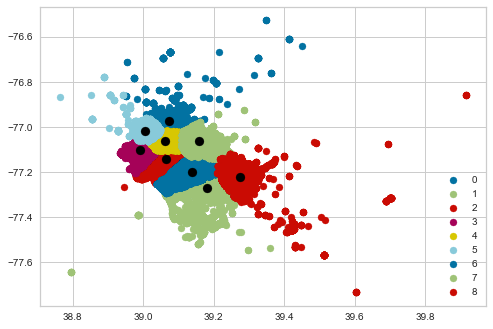

In [60]:
kmeans = KMeans(n_clusters=9, random_state=0)
label = kmeans.fit_predict(geolocation[0:size,])

new_geolocation = geolocation[0:size,]
location_with_label = np.zeros((size, 3))


for i in range(size):
    location_with_label[i][0] = new_geolocation[i][0]
    location_with_label[i][1] = new_geolocation[i][1]
    location_with_label[i][2] = label[i]

u_labels = np.unique(label)
for i in u_labels:
    filtered_label = location_with_label[location_with_label[:,2] == i]
    plt.scatter(filtered_label[:,0] , filtered_label[:,1] , label = i)
plt.scatter(kmeans.cluster_centers_[:,0] , kmeans.cluster_centers_[:,1] , s = 80, color = 'black')
plt.legend()
plt.show()

39.9147366666667

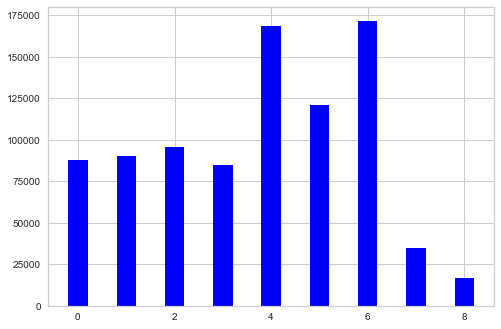

In [61]:
label_count = {}
for i in u_labels:
    filtered_label = location_with_label[location_with_label[:,2] == i]
    # print(np.max(filtered_label[:,0]), np.min(filtered_label[:,0]))
    # print(np.max(filtered_label[:,1]), np.min(filtered_label[:,1]))

    label_count[i] = filtered_label.shape[0]
plt.bar(u_labels, list(label_count.values()), color ='blue',
        width = 0.4)
np.max(location_with_label[:,0])

<AxesSubplot:>

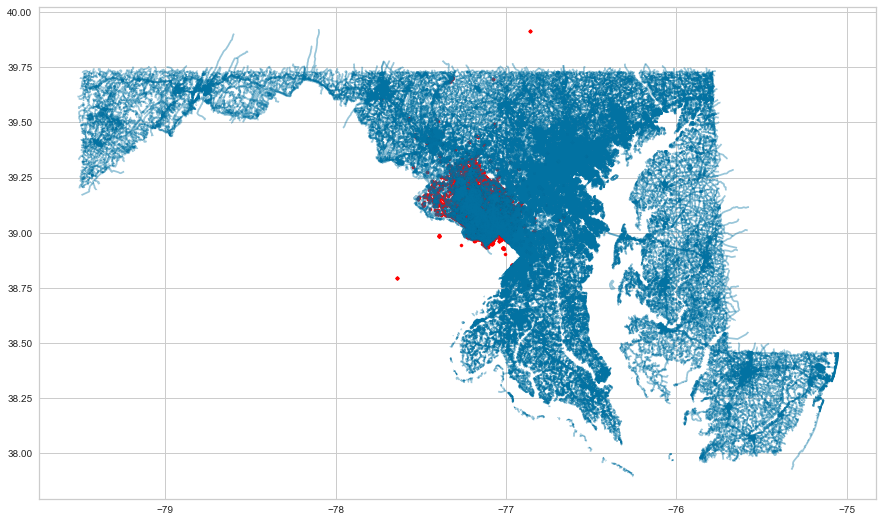

In [62]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

import shutil
shutil.unpack_archive("./roads/main.zip", "./roads/", "zip")

usa = gpd.read_file("C:\\Users\\A02351046\\cs5830_final\\roads\\gis_osm_roads_free_1.shp")

geometry = [Point(xy) for xy in zip(location_with_label[:,1], location_with_label[:,0])]

geo_df = gpd.GeoDataFrame(crs = usa.crs, geometry = geometry)
fig, ax = plt.subplots(figsize=(15,15))
usa.plot(ax=ax, alpha = 0.4)
geo_df.plot(ax=ax, color='red', markersize=10)